In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

from numba import jit
import time
import gc

In [2]:
from sklearn.model_selection import train_test_split  

In [3]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [4]:
# Compute gini
@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

In [5]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

In [6]:
def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    #assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)['target'].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': 'target', 'target': 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': 'target', 'target': 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)


In [7]:
train_features = [
    "ps_car_13",  #            : 1571.65 / shadow  609.23
	"ps_reg_03",  #            : 1408.42 / shadow  511.15
	"ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
	"ps_ind_03",  #            : 1219.47 / shadow  230.55
	"ps_ind_15",  #            :  922.18 / shadow  242.00
	"ps_reg_02",  #            :  920.65 / shadow  267.50
	"ps_car_14",  #            :  798.48 / shadow  549.58
	"ps_car_12",  #            :  731.93 / shadow  293.62
	"ps_car_01_cat",  #        :  698.07 / shadow  178.72
	"ps_car_07_cat",  #        :  694.53 / shadow   36.35
	"ps_ind_17_bin",  #        :  620.77 / shadow   23.15
	"ps_car_03_cat",  #        :  611.73 / shadow   50.67
	"ps_reg_01",  #            :  598.60 / shadow  178.57
	"ps_car_15",  #            :  593.35 / shadow  226.43
	"ps_ind_01",  #            :  547.32 / shadow  154.58
	"ps_ind_16_bin",  #        :  475.37 / shadow   34.17
	"ps_ind_07_bin",  #        :  435.28 / shadow   28.92
	"ps_car_06_cat",  #        :  398.02 / shadow  212.43
	"ps_car_04_cat",  #        :  376.87 / shadow   76.98
	"ps_ind_06_bin",  #        :  370.97 / shadow   36.13
	"ps_car_09_cat",  #        :  214.12 / shadow   81.38
	"ps_car_02_cat",  #        :  203.03 / shadow   26.67
	"ps_ind_02_cat",  #        :  189.47 / shadow   65.68
	"ps_car_11",  #            :  173.28 / shadow   76.45
	"ps_car_05_cat",  #        :  172.75 / shadow   62.92
	"ps_calc_09",  #           :  169.13 / shadow  129.72
	"ps_calc_05",  #           :  148.83 / shadow  120.68
	"ps_ind_08_bin",  #        :  140.73 / shadow   27.63
	"ps_car_08_cat",  #        :  120.87 / shadow   28.82
	"ps_ind_09_bin",  #        :  113.92 / shadow   27.05
	"ps_ind_04_cat",  #        :  107.27 / shadow   37.43
	"ps_ind_18_bin",  #        :   77.42 / shadow   25.97
	"ps_ind_12_bin",  #        :   39.67 / shadow   15.52
	"ps_ind_14",  #            :   37.37 / shadow   16.65
    #'ps_reg_F',
    #'ps_reg_M'
]
# add combinations
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]


In [8]:
# Read data
train_df = pd.read_csv('../../data/train.csv', na_values="-1") # .iloc[0:200,:]
test_df = pd.read_csv('../../data/test.csv', na_values="-1")
print('imported data')

# Process data
id_test = test_df['id'].values
id_train = train_df['id'].values
y = train_df['target']

print('begining feature engineering')
start = time.time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('\n\tCurrent feature %60s %4d in %5.1f'
          % (name1, n_c + 1, (time.time() - start) / 60), end='')
    print('\r' * 75, end='')
    train_df[name1] = train_df[f1].apply(lambda x: str(x)) + "_" + train_df[f2].apply(lambda x: str(x))
    test_df[name1] = test_df[f1].apply(lambda x: str(x)) + "_" + test_df[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(train_df[name1].values) + list(test_df[name1].values))
    train_df[name1] = lbl.transform(list(train_df[name1].values))
    test_df[name1] = lbl.transform(list(test_df[name1].values))

    train_features.append(name1)
    
X = train_df[train_features]
test_df = test_df[train_features]

print('\nDone adding features, smoothing categorical featuers now.. ')
#target categoricals 
f_cats = [f for f in X.columns if "_cat" in f]

for f in f_cats:
    X[f + "_avg"], test_df[f + "_avg"] = target_encode(trn_series=X[f],
                                         tst_series=test_df[f],
                                         target=train_df['target'],
                                         min_samples_leaf=200,
                                         smoothing=10,
                                         noise_level=0)
print('Done ... I can start learning now.. ')

imported data
begining feature engineering

	Current feature                                 ps_reg_01_plus_ps_car_02_cat    1 in   0.0
	Current feature                                 ps_reg_01_plus_ps_car_04_cat    2 in   0.0
Done adding features, smoothing categorical featuers now.. 
Done ... I can start learning now.. 


In [9]:
X = X.fillna(-1)
test_df = test_df.fillna(-1)
y_valid_pred = 0*y
y_test_pred = 0

In [10]:
class EnsambleHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state']= seed
        self.clf = clf(**params)
        #self.clf = CalibratedClassifierCV(clf(**params), cv=5)
#         if clf != XGBClassifier:
#             self.clf = CalibratedClassifierCV(clf(**params), cv=5)
#         else:
#             self.clf = clf(**params)
    
    def train(self,X_train, y_train):
        #cccv = CalibratedClassifierCV(self.clf, cv=StratifiedKFold(y_train, n_folds=5, random_state=42, shuffle=True))
        #cccv.fit(X_train, y_train)
        self.clf.fit(X_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def features_importance(self, x, y):
        print(self.clf.fit(x,y).features_importance_)

In [11]:
def get_oof(clf, X_train, y_train, X_test, K =5, SEED =43 ):
    
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    kf = KFold(n_splits = K, random_state = 42, shuffle = True)
    oof_train = np.zeros((X_train.shape[0],))
    oof_test  = np.zeros((X_test.shape[0],))
    oof_test_skf = np.empty((K, X_test.shape[0]))
    
    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_train_k = X_train[train_index]
        y_train_k = y_train[train_index]
        X_test_k =  X_train[test_index]
        y_test_k = y_train[test_index]
        
        clf.train(X_train_k, y_train_k)
        
        train_pred = clf.predict_proba(X_train_k)[:,1]
        test_pred = clf.predict_proba(X_test_k)[:,1]
        oof_train[test_index] = clf.predict_proba(X_test_k)[:,1]
        oof_test_skf[i,:] = clf.predict_proba(X_test)[:,1]
        
        print( "Fold {}:  Train-Gini = {:06.5f}, Eval-Gini = {:06.5f}".format(i,eval_gini(y_train_k, train_pred),eval_gini(y_test_k, test_pred)))
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [39]:
def blend(clf, X_train, y_train, X_test, K =5, SEED =43 ):
    y_test_pred = 0
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    kf = KFold(n_splits = K, random_state = 1, shuffle = True)

    
    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_train_k = X_train[train_index]
        y_train_k = y_train[train_index]
        X_test_k =  X_train[test_index]
        y_test_k = y_train[test_index]
        
        clf.fit(X_train_k, y_train_k)
        train_pred = clf.predict_proba(X_train_k)[:,1]
        pred = clf.predict_proba(X_test_k)[:,1]
        y_test_pred += clf.predict_proba(X_test)[:,1]/K
        
        print( "Fold {}:  Train-Gini = {:06.5f}, Eval-Gini = {:06.5f}".format(i,eval_gini(y_train_k, train_pred),eval_gini(y_test_k, pred)))
    
    return y_test_pred

In [13]:
x_train = X.values
y_train = y.values
x_test = test_df.values

In [30]:
rf_params = {
     'n_jobs': -1,
     'criterion': 'gini',
     'max_depth': 20,
     'max_features': 4,
     'max_leaf_nodes': 20,
     'min_samples_leaf': 0.1,
     'min_samples_split': 0.15,
     'n_estimators': 54,
     'class_weight':'balanced_subsample'
}


#Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':60,
    'max_depth': 8,
    'min_weight_fraction_leaf':0.0,
    'min_samples_leaf': 3,
    'verbose': 0,
    'bootstrap': False,
    #'min_samples_split': 4,
    'max_features':  'log2',
}

# AdaBoost parameters
# ada_params = {
#     'base_estimator' :ExtraTreesClassifier(max_depth=4, n_estimators=5,n_jobs=-1,min_samples_leaf=1),
#     'n_estimators': 50,
#     'learning_rate' : 0.75
# }

# AdaBoost parameters
ada_params = {
    'base_estimator' :ExtraTreesClassifier(max_depth=4, n_estimators=50,n_jobs=-1,min_samples_leaf=1),
    'n_estimators': 25,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'max_leaf_nodes':None,
    'max_features':None,
    'learning_rate':0.1,
    'loss':'deviance',
    'presort':True,
    'min_samples_split':2,
    'min_weight_fraction_leaf':0.0,
    'min_impurity_decrease':0.0,
    'subsample':1.0,
    'min_impurity_split':None,
    'n_estimators': 100,
     #'max_features': 0.2,
    'max_depth': 3,
    'min_samples_leaf': 1,
    'verbose': 0,
    'max_leaf_nodes':None,
}
# # Gradient Boosting parameters
# gb_params = {
#     'learning_rate':0.1
#     'n_estimators': 50,
#      #'max_features': 0.2,
#     'max_depth': 5,
#     'min_samples_leaf': 2,
#     'verbose': 0
# }

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

params = {'tree_method':'gpu_hist', 'predictor':'gpu_predictor'}

xgb_params = {'n_estimators':450,
                'max_depth':4,
                'objective':"binary:logistic",
                'learning_rate':0.07,
                'max_delta_step':1.8,
                'subsample':.8,
                #min_child_weight=0.5,
                'colsample_bytree': 0.8,
                'min_child_weight':28,#??
                'colsample_bylevel':0.432,#??
                'gamma':10,
                'reg_alpha':8,
               'n_jobs':12,
                'reg_lambda':1.3,
                'missing':-1,
                **params}

In [31]:
SEED=42

In [32]:
rf = EnsambleHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = EnsambleHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = EnsambleHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = EnsambleHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = EnsambleHelper(clf=SVC, seed=SEED, params=svc_params)
xgb = EnsambleHelper(clf=XGBClassifier, seed=SEED, params=xgb_params)

In [23]:
svc_oof_train, svc_oof_test = get_oof(xgb,x_train, y_train, x_test) # Support Vector Classifier

Fold 0:  Train-Gini = 0.36106, Eval-Gini = 0.27325
Fold 1:  Train-Gini = 0.35715, Eval-Gini = 0.29476
Fold 2:  Train-Gini = 0.35773, Eval-Gini = 0.28519
Fold 3:  Train-Gini = 0.35739, Eval-Gini = 0.29556
Fold 4:  Train-Gini = 0.35776, Eval-Gini = 0.28903


In [18]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees

Fold 0:  Train-Gini = 0.29177, Eval-Gini = 0.23725
Fold 1:  Train-Gini = 0.28925, Eval-Gini = 0.25948
Fold 2:  Train-Gini = 0.28736, Eval-Gini = 0.25527
Fold 3:  Train-Gini = 0.28646, Eval-Gini = 0.26026
Fold 4:  Train-Gini = 0.28707, Eval-Gini = 0.26039


In [24]:
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest

Fold 0:  Train-Gini = 0.21055, Eval-Gini = 0.17645
Fold 1:  Train-Gini = 0.20417, Eval-Gini = 0.20363
Fold 2:  Train-Gini = 0.20484, Eval-Gini = 0.20837
Fold 3:  Train-Gini = 0.20558, Eval-Gini = 0.21113
Fold 4:  Train-Gini = 0.20039, Eval-Gini = 0.20930


In [33]:
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 

Fold 0:  Train-Gini = 0.31844, Eval-Gini = 0.26736
Fold 1:  Train-Gini = 0.31323, Eval-Gini = 0.28808
Fold 2:  Train-Gini = 0.31486, Eval-Gini = 0.28189
Fold 3:  Train-Gini = 0.31397, Eval-Gini = 0.28856
Fold 4:  Train-Gini = 0.31503, Eval-Gini = 0.28580


In [34]:
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost

Fold 0:  Train-Gini = 0.30260, Eval-Gini = 0.26091
Fold 1:  Train-Gini = 0.29840, Eval-Gini = 0.28695
Fold 2:  Train-Gini = 0.29877, Eval-Gini = 0.27809
Fold 3:  Train-Gini = 0.29790, Eval-Gini = 0.28616
Fold 4:  Train-Gini = 0.29884, Eval-Gini = 0.28148


In [35]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                       'ExtraTrees': et_oof_train.ravel(),
                                       'XGBoost': svc_oof_train.ravel(),
                                       'AdaBoost': ada_oof_train.ravel(),
                                       'GBoost': gb_oof_train.ravel()})
base_predictions_train.head()

,AdaBoost,ExtraTrees,GBoost,RandomForest,XGBoost
0,0.458870,0.047472,0.044198,0.505484,0.044113
1,0.454031,0.032741,0.035664,0.482431,0.026422
2,0.448267,0.027043,0.021208,0.448453,0.019910
3,0.446240,0.026823,0.017561,0.479430,0.017558
4,0.454641,0.028133,0.031373,0.479002,0.044170


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcbe86e8278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fcbceab5320>]], dtype=object)

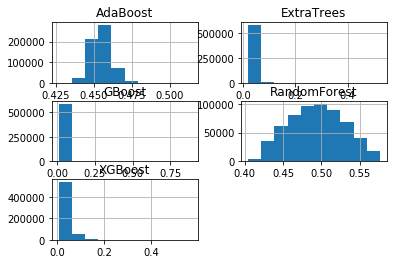

In [36]:
base_predictions_train.hist()

In [ ]:


data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')



In [57]:
x_train_blender= np.concatenate((et_oof_train, svc_oof_train,gb_oof_train,ada_oof_train), axis=1)
x_test_blender = np.concatenate((et_oof_test, svc_oof_test,gb_oof_test,ada_oof_test), axis=1)

In [107]:
mdl = XGBClassifier(n_estimators= 500,learning_rate=0.007, max_depth= 4,min_child_weight= 1,gamma=.8,subsample=1,
                    colsample_bytree=1,objective= 'binary:logistic',scale_pos_weight=2,**params)
predictions = blend(mdl,x_train_blender, y_train, x_test_blender)

Fold 0:  Train-Gini = 0.29923, Eval-Gini = 0.27135
Fold 1:  Train-Gini = 0.29363, Eval-Gini = 0.29476
Fold 2:  Train-Gini = 0.29578, Eval-Gini = 0.28599
Fold 3:  Train-Gini = 0.29340, Eval-Gini = 0.29443
Fold 4:  Train-Gini = 0.29364, Eval-Gini = 0.29072


In [108]:
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = predictions
filename = 'ensamble_'+str(dt.datetime.now()).replace(' ','_').replace(':','').replace('.','')
sub.id = sub.id.astype('Int32')
sub.to_csv('../../output/'+filename+'.csv.gz', index=False,compression='gzip')

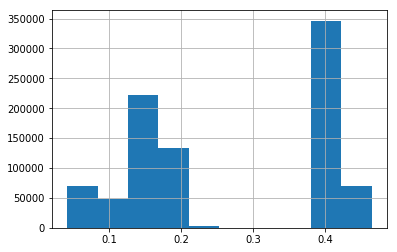

In [109]:
sub['target'].hist()

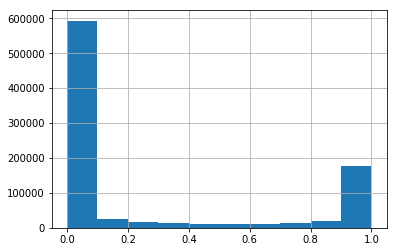

In [103]:
sub['target'].hist()
plt.show()

## Keras

In [ ]:
import tensorflow as tf

In [47]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization 
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.utils import np_utils

Using TensorFlow backend.


In [48]:
from sklearn.metrics import f1_score, roc_auc_score
import keras.callbacks as kc

class Metrics(kc.Callback):
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict_proba(self.validation_data[0])[:,0])
        targ = self.validation_data[1]
        self.ginis= eval_gini(targ, predict)
        return
metrics = Metrics()

In [126]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=4, kernel_initializer='glorot_uniform',bias_initializer='zeros', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(),metrics=['acc'])
    return model

In [127]:
model = baseline_model()

In [128]:
RS = StandardScaler()
RS.fit(list(x_train_blender) + list(x_test_blender))
x_train_blender_in = RS.transform(x_train_blender)
x_test_blender_in = RS.transform(x_test_blender)

In [129]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

NUM_EPOCHS = 20
BATCH_SIZE = 32

sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = np.zeros_like(id_test)

for i, (train_index, test_index) in enumerate(skf.split(x_train_blender_in, y_train)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train_blender_dl, X_valid_blender_dl = x_train_blender[train_index], x_train_blender[test_index]
    y_train_blender_dl, y_valid_blender_dl = y_train[train_index], y_train[test_index]
    #class_weight = {1 : (len(y_train) - sum(y_train))/y_train.shape[0], 0: sum(y_train)/y_train.shape[0]}
    ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=1, mode='auto')
    history = model.fit(X_train_blender_dl, y_train_blender_dl, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,validation_data=(X_valid_blender_dl,y_valid_blender_dl), callbacks=[ES,metrics])#, class_weight = class_weight
    print(metrics.ginis)
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test =model.predict_proba(x_test_blender_in)[:,0]
    sub['target'] += p_test/kfold

[Fold 1/5]
Train on 476169 samples, validate on 119043 samples
Epoch 1/20
476169/476169 [==============================] - 28s - loss: 0.1617 - acc: 0.9632 - val_loss: 0.1527 - val_acc: 0.9635
Epoch 2/20
476169/476169 [==============================] - 28s - loss: 0.1542 - acc: 0.9635 - val_loss: 0.1525 - val_acc: 0.9635
Epoch 3/20
476169/476169 [==============================] - 28s - loss: 0.1531 - acc: 0.9636 - val_loss: 0.1520 - val_acc: 0.9636
Epoch 4/20
476169/476169 [==============================] - 28s - loss: 0.1524 - acc: 0.9635 - val_loss: 0.1518 - val_acc: 0.9636
Epoch 5/20
476169/476169 [==============================] - 28s - loss: 0.1522 - acc: 0.9635 - val_loss: 0.1518 - val_acc: 0.9636
Epoch 6/20
476169/476169 [==============================] - 28s - loss: 0.1521 - acc: 0.9635 - val_loss: 0.1518 - val_acc: 0.9636
Epoch 00005: early stopping
[ 0.28844492]
[Fold 1/5 Prediciton:]
891136/892816 [============================>.] - ETA: 0s[Fold 2/5]
Train on 476169 samples, 

In [106]:
filename = 'dl_ensamble_'+str(dt.datetime.now()).replace(' ','_').replace(':','').replace('.','')
sub.id = sub.id.astype('Int32')
sub.to_csv('../../output/'+filename+'.csv.gz', index=False,compression='gzip')

In [94]:
sub['id'] = id_test

In [95]:
sub

,id,target
0,0,6.046914e-10
1,1,4.148240e-09
2,2,1.253105e-09
3,3,8.457876e-17
4,4,3.579004e-04
5,5,8.017893e-01
6,6,1.420868e-12
7,8,1.048186e-04
8,10,9.900000e-01
9,11,9.900000e-01


In [105]:
sub[sub['target']>0.99]=0.99